# Flux measurements training SFERA-III STT16
Anita Haeussler, PROMES Laboratory

![](https://user-images.githubusercontent.com/102672251/273207866-dcb95a2f-e0ce-4be5-98be-cffc38b9d398.png)
![promes_haute_resolution](https://user-images.githubusercontent.com/102672251/273208814-195fb560-b728-41a4-9fca-87c122d2ae3e.jpg)
![cnrs](https://user-images.githubusercontent.com/102672251/273209781-d2635dca-5fa4-4ec4-be24-85547c09adbb.png)

# Radiometric calibration
This modules aims to obtain the conversion factor between grey levels to power density

# Principe
The radiometric calibration aims to convert the grey levels on a image to power density value. So it is necessary to measure a solar power density and associate it with the corresponding grey level. The calorimeter used to describe the solar power density is represented below. 
![schema_calorimetre](https://user-images.githubusercontent.com/102672251/273208710-96fd7a98-0f64-41af-9fb1-daf2b830324d.png)


# How to obtain the conversion from grey levels to power density ?
![](https://user-images.githubusercontent.com/102672251/273208428-bd34c92c-c552-4ee3-bb92-f211675e3be3.png)

In [2]:
# Matrice management
import numpy as np
# System interphase
import os
# Images management
import cv2
from PIL import Image
# Graphic
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# To import (homemade) jupyter Notebooks
import import_ipynb

# Homemade notebooks
import general_functions as functions

importing Jupyter notebook from general_functions.ipynb


## Calorimeter image
The position of the calorimeter apperture should be detected to use this poisition. Two methods can be used :
 * Position detaction with SimpleBlobDetector
 * External mesaurement with Fidji

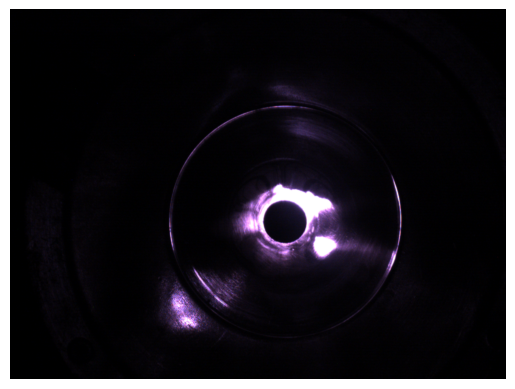

In [19]:
calo_img_path = os.path.join(functions.FOLDER_PATH, "calorimetrie\\img_calo")
img_names = [name for name in os.listdir(calo_img_path)
            if name.endswith(".tiff")]
img_path = os.path.join(calo_img_path, img_names[0])
img_calo = cv2.imread(img_path, -1)
img_calo = np.intc(img_calo/np.amax(img_calo)*255)
img_calo = img_calo.astype('uint8')
img_calo2save = Image.fromarray(img_calo, "RGB")

if __name__ == "__main__":
    plt.imshow(img_calo2save)
    plt.axis("off")
    storage_path = os.path.join(functions.FOLDER_PATH, "calorimetrie\\img_calo.png")
    img_calo2save.save(storage_path)
    plt.show()

### SimpleBlobDetector
cf : https://learnopencv.com/blob-detection-using-opencv-python-c/

In [ ]:
# Detector definition
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 100
params.maxArea = 10000
version = int((cv2.__version__).split('.')[0])
if version < 3:
    detector = cv2.SimpleBlobDetector(params)
else:
    detector = cv2.SimpleBlobDetector_create(params)
    
# Point detection
keypoints = detector.detect(img_calo)
ellipse_blob_dect = ((keypoints[0].pt[0], keypoints[0].pt[1]),
            (keypoints[0].size/2, keypoints[0].size/2))

### Fiji
Use of Fiji to determine circle coordinates :
((center_X, center_Y), (Dx, Dy))


In [ ]:
ellipse_fiji = ((715,554),
               (114/2,112/2))

### Display

In [ ]:
if __name__ == "__main__":
    calo_disp = img_calo.copy()
    # img = np.asarray(img)
    (centre_X, centre_Y), (diam, _) = ellipse_fiji
    cv2.circle(calo_disp, (centre_X, centre_Y), int(diam),
                       (0, 0, 180), 5)
    (centre_X, centre_Y), (diam, _) = ellipse_blob_dect
    cv2.circle(calo_disp, (int(centre_X), int(centre_Y)), int(diam),
                       (0, 105, 180), 5)
    plt.imshow(calo_disp)
    plt.show()


# Target image 

In [ ]:
target_img_path = os.path.join(functions.FOLDER_PATH, "calorimetrie\\img_cible")

## Parameters of the camera
`PETALE2` software has been developed at the PROMES laboratory to acquire a number of images from the camera at maximum speed, with the date and time of each image. For each series of images, the `PETALE2` software creates a log file in which the camera parameters used are stored, along with the date and time of each image. 

In [ ]:
# Get the name of the log file
log_name = [log for log in os.listdir(target_img_path) if log.endswith(".txt")][0]
# Get the log path
log_path = os.path.join(target_img_path, log_name)
parameters = functions.get_img_parameters(log_path)

## Get raw images

In [ ]:
img_names = [name for name in os.listdir(target_img_path)
             if name.endswith(".tiff")]
target_imgs = np.empty((len(img_names), 964, 1292), np.float64)
for idx, img_name in enumerate(img_names):
    img_path = os.path.join(target_img_path, img_name)
    # Read image
    img = cv2.imread(img_path, -1)
    # Split images in RGB channels
    img = cv2.split(img)
    # Keep the red channel
    img = img[0]
    # Store images
    target_imgs[idx, :, :] = img

## DNI normalization

In [ ]:
for idx, img_name in enumerate(img_names):
    ## Acquisition time
    img_time = [img_name[29:31],  # hour
                img_name[31:33],  # minute
                img_name[33:39]]  # second
    # DNI at the instant of the image
    img_DNI = functions.get_DNI(parameters["Date"], img_time)
    img  = target_imgs[idx, :, :]
    # DNI normalization
    img = img * functions.NORM_DNI / img_DNI
    target_imgs[idx, :, :] = img

## Build the image with Median of Means method

In [ ]:
nb_img = len(target_imgs)
nb_pix = 10
orded_imgs = np.sort(target_imgs, axis=0,
                 kind="quicksort", order=None)
orded_imgs = orded_imgs[(nb_img-nb_pix)//2:
                    (nb_img+nb_pix)//2, :, :]
img_med_mean = np.mean(orded_imgs, axis=0)

target_img = img_med_mean

## Display

In [ ]:
if __name__ == "__main__":
    target_disp = target_img.copy()
    cv2.circle(target_disp, (int(centre_X), int(centre_Y)), int(diam),
                       (np.max(target_disp)), 5)
    plt.imshow(target_disp)
    plt.axis("off")
    plt.show()

# Mean grey level corresponding at the calorimeter aperture surface

## Function ellipse
A point $M(x, y) \in E$ if
$ 1\le \left(\frac{x-c_x}{r_x}\right)^2 +\left(\frac{y-c_y}{r_y}\right)^2 $

![](ellipse.png)

In [ ]:
def is_point_in_ellipse(point, ellipse_coords):
    # M coordinate 
    x, y = point
    # Ellipse coordinate
    (cx, cy), (rx, ry) = ellipse_coords
    # Ellipse cartesian equation
    test = 1 <= ((x-cx)/rx)**2+((y-cy)/ry)**2
    return test

## Mask creation
Create a mask containing which correspond to the calorimeter's diaphragrm apperture

In [ ]:
# Ellipse coordinate
coords_ellipse = ellipse_blob_dect
# Creation to an empty mask
nb_pixel_y,  nb_pixel_x = target_img.shape
mask = np.zeros((nb_pixel_y, nb_pixel_x))
# Check for all the pixels of the image
for pixel_x in range(nb_pixel_x):
    for pixel_y in range(nb_pixel_y):
        # Point M
        coords_pixel = (pixel_x, pixel_y)
        # Check if the M point is in the ellipse
        bool_ellipse = is_point_in_ellipse(coords_pixel,
                                           coords_ellipse)
        if bool_ellipse:
            # If the M in E, mask sets to 0
            mask[pixel_y,pixel_x] = 1

## Masked target image
From the previously created mask and the target image, a new image is created where only the pixels corresponding to the aperture are taken into account. 

In [ ]:
masked_target = np.ma.masked_where(mask, target_img)

## Display 

In [ ]:
if __name__ == "__main__":
    fig, axs= plt.subplots(2, 2, figsize=(10, 10))
    # fig.
    # Calorimeter
    axs[0, 0].set_title("Calorimeter")
    axs[0, 0].imshow(calo_disp)

    # Target
    axs[0, 1].set_title("Target")
    axs[0, 1].imshow(target_disp)

    # Masked target
    axs[1, 1].set_title("Masked target")
    axs[1, 1].imshow(masked_target)

    # formatting
    for ax in axs.flatten():
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_major_locator(ticker.NullLocator())
    axs[1, 0].axis("off")
    plt.show()

## Mean grey level

In [ ]:
mean_GL = np.mean(masked_target)
if __name__ == "__main__":
    print("Average grey level on diaphragm aperture :")
    print(f"{mean_GL: 0.2} GL")

# Power measurement

## Read file

In [ ]:
power_file_path =os.path.join(functions.FOLDER_PATH, "calorimetrie\\C-SE_500.2023-05-10_11-10-15.txt")
calo_file = open(power_file_path, "r+")
lines = calo_file.readlines()
nb_lines = len(lines[4:])
time = []
# (W/m²) Direct Normal Irradiation
DNI = np.zeros(nb_lines, np.float64)
# (°C) Thermocouple T1 temperature
T1 = np.zeros(nb_lines, np.float64)
# (°C) Thermocouple T2 temperature
T2 = np.zeros(nb_lines, np.float64)
# (g/min) water flow
Q = np.zeros(nb_lines, np.float64)
date = lines[1][17:-10]

for idx, line in enumerate(lines[4:]):
    time.append(functions.read_time(line))
    DNI[idx] = functions.read_DNI(line) # (W/m²)
    T1[idx] = functions.read_T1(line) # (°C)
    T2[idx] = functions.read_T2(line) # (°C)
    Q[idx] = functions.read_flow(line) # (g/min)
calo_file.close()

## Power calculation
$ P = Q Cp_{H_2O} |T1-T2|$

with :
* $Q$, water flow in g/s
* $Cp_{H_2O}$, Isobaric mass heat capacity in J/g/K
* $T1$, n°1 thermocouple temperature in K
* $T2$, n°2 thermocouple temperature in K


In [ ]:
# Calculation of the power
power = Q / 60 * functions.Cp_H2O * abs(T1-T2) # (J/s)
# Normalisation of the power with DNI
power_norm = power / DNI * 1000
# Average value of the power during the experiment
mean_power = np.mean(power_norm)
# Power density
power_density = mean_power / functions.DIAPH_SURF

## Display

In [ ]:
if __name__ == "__main__":
    print(f"Mean power : {mean_power: 0.2f} J/s")
    print(f"Power density: {power_density: 0.2f} J/s/m²")
    plt.plot(time, power)
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_ylabel("Power (J/s)")
    ax.set_xlabel("Time")
    plt.show()

# Factor to convert grey levels to power density

In [ ]:
GL2density_factor = power_density/mean_GL
if __name__ == "__main__":
    print(f"{GL2density_factor: 0.2f} W/m²/GL/pixel")